#Problème n°1

La bonne transmission de signaux électromagnétiques dans l'atmosphère peut dépendre de la météo. La pluie affecte notoirement les échanges entre les antennes relais des réseaux mobiles actuels. C'est une gêne, mais aussi une opportunité: l'atténuation des ondes électromagnétiques due à la pluie peut être mesurée et utilisée comme un moyen de quantifier les précipitations.

Dans ce problème, on s'intéresse à la conversion de l'atténuation, définie comme un rapport entre puissance émise et puissance reçue et exprimée en dB, en un taux de pluie moyen le long de segments physiques dont les extrémités sont des paires d'antennes relais.

Evidemment, d'autres éléments que le pluie, plus ou moins bien connus, peuvent influencer l'atténuation. La simulation sur laquelle nous allons travailler, qui porte sur un millier de paires d'antennes virtuelles, est construite de la façon suivante:

- pour une paire d'antennes donnée, on modélise une série temporelle de taux de pluie moyen par un processus stochastique dont les paramètres dépendent entre autres de la distance qui sépare les antennes.
- pour en tirer des atténuations, on applique à cette série les transformations suivantes:
    - un filtre convolutif, censé modéliser l'impact du film d'eau se formant sur les antennes au cours d'un épisode de pluie.
    - une conversion non-linéaire, tirée d'un modèle physique, est appliquée composante à composante.
 épisode pluvieux (ce film qui s'épaissit augmente progressivement l'atténuation).
    - un bruit haute-fréquence
    - un bruit basse fréquence

La cellules suivantes permettent de récupérer les briques de code utiles, de construire un dictionnaire contenant des identifiants de paires d'antennes (clefs) et les distances les séparant (valeurs). La dernière cellule montre des exemples de séries temporelles simulées pour quelques paires.

In [1]:
# Local clone
! git clone https://github.com/ZinebZaad/exam_2025.git
! cp exam_2025/utils/utils_probleme1.py .

Cloning into 'exam_2025'...
remote: Enumerating objects: 79, done.
remote: Counting objects: 100% (15/15), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 79 (delta 7), reused 3 (delta 3), pack-reused 64 (from 1)
Receiving objects: 100% (79/79), 1.43 MiB | 11.66 MiB/s, done.
Resolving deltas: 100% (25/25), done.


In [2]:
# Imports
from os.path import join, isdir, isfile
from os import listdir as ls
import copy
import torch
import numpy as np
import sys
from utils_probleme1 import create_dataloader

In [3]:
# Dictionnaire des "distances" (générées au hasard)
idx2distance_train = {i: 0.2 +  1.8 * torch.rand((1,)).item() for i in range(0, 1000)}
idx2distance_val = {i: 0.2 +  1.8 * torch.rand((1,)).item() for i in range(1000, 1200)}

# Paramètres de la simulation
duration = 4096  # durée de la série temporelle (unité : minutes)
batch_size = 100  # taille d'un échantillon

# Création du dataloader (il contient toutes les étapes de la simulation)
# (en une époque, chaque paire d'antennes du dictionnaire idx2distance
# a été tirée exactement une fois)
trainloader = create_dataloader(duration, idx2distance_train, batch_size)

# Génération d'un batch contenant des séries temporelles
for batch_idx, (ids, dists, rain_rates, attenuations) in enumerate(trainloader):
    break

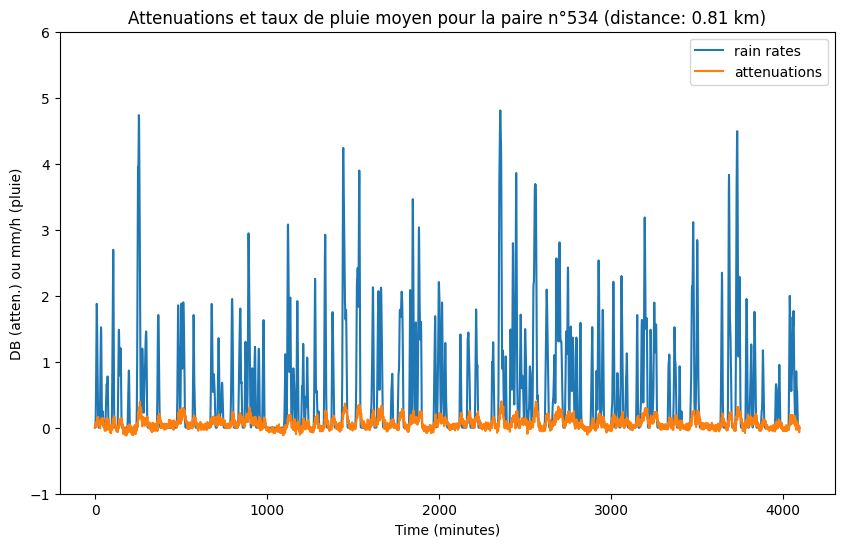

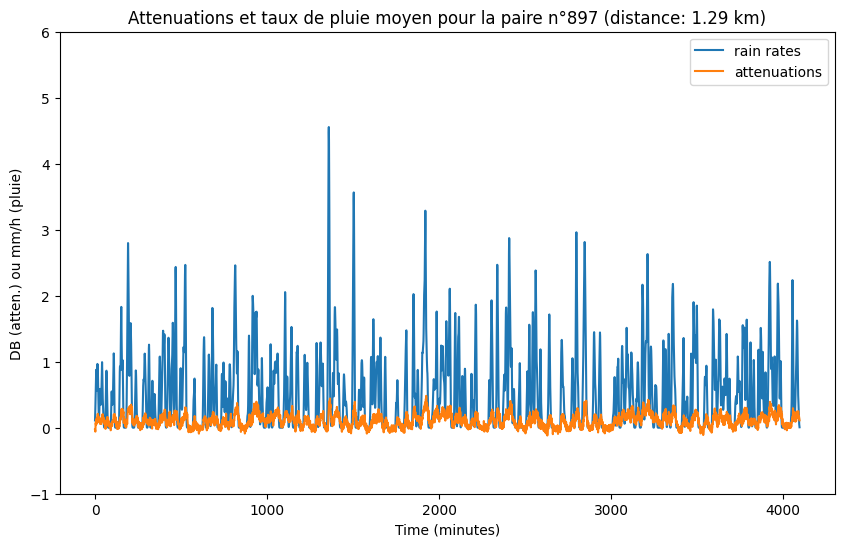

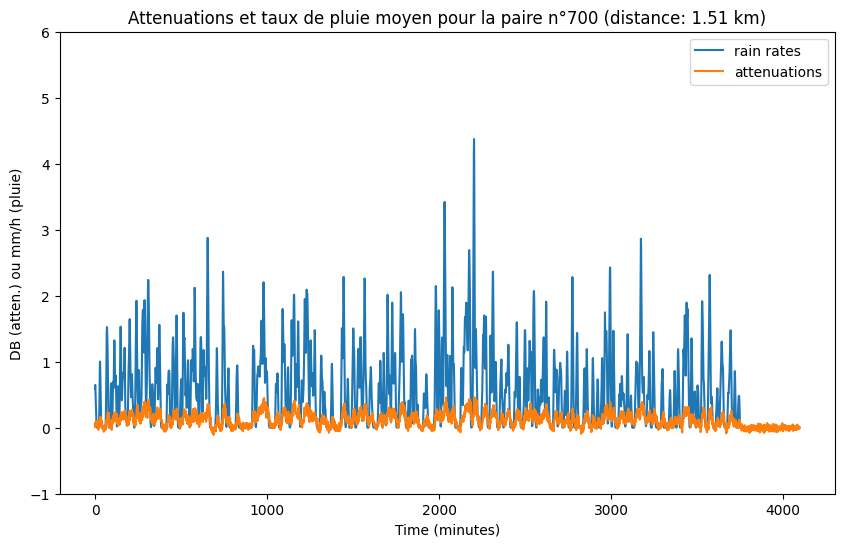

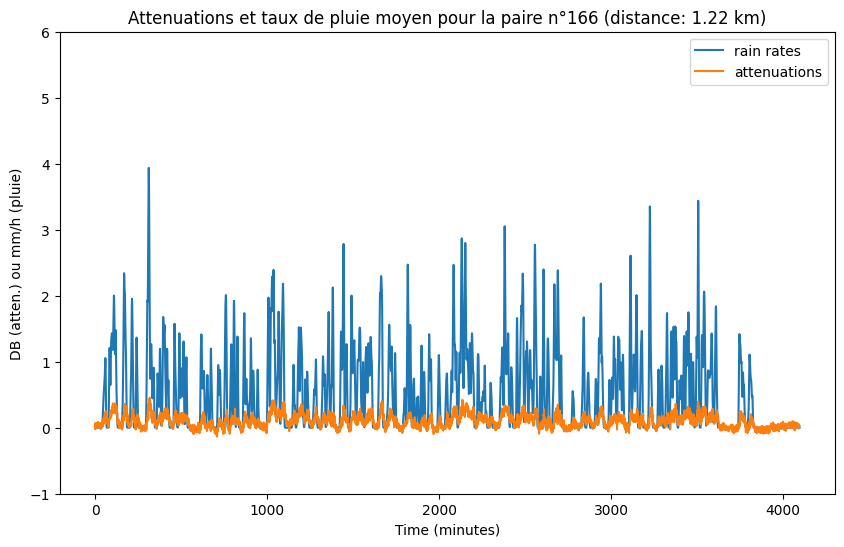

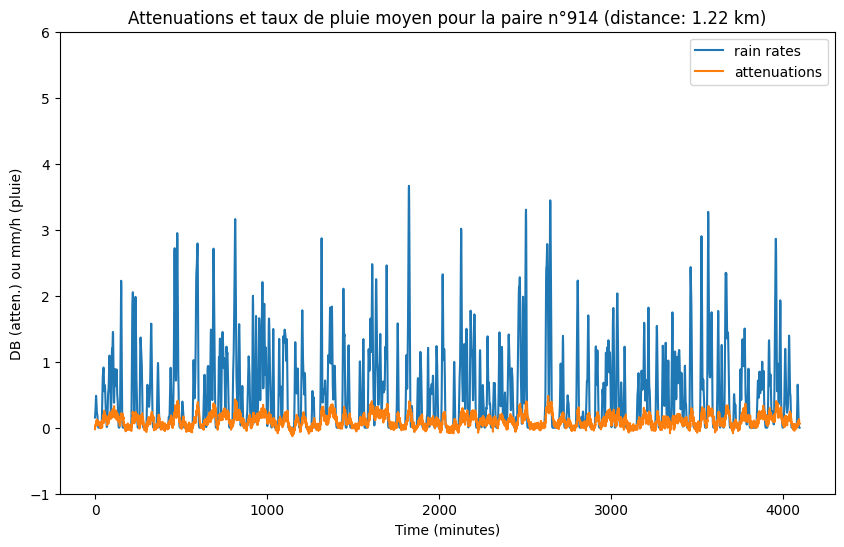

In [4]:
import matplotlib.pyplot as plt

for k in range(5):
  plt.figure(figsize=(10, 6))
  plt.plot(np.arange(duration), rain_rates[k], label='rain rates')
  plt.plot(np.arange(duration), attenuations[k], label='attenuations')
  plt.title(f"Attenuations et taux de pluie moyen pour la paire n°{ids[k].item():.0f} (distance: {dists[k].item():.2f} km)")
  plt.xlabel('Time (minutes)')
  plt.ylabel('DB (atten.) ou mm/h (pluie)')
  plt.ylim(-1,6)
  plt.legend()
  plt.show()

## Partie I : Un réseau de neurones générique

# A partir des briques de base

Dans cette partie, on entraîne un UNet1D à faire le lien entre atténuations
et taux de pluie. Les cellules suivantes contiennent les blocs du UNet1D et son montage :

**Consignes:** \
1) Entraîner sur GPU un UNet 1D à restituer les taux de pluie à partir des atténuations.
- On utilisera la MSE comme fonction de coût et comme score. Dans les deux cas, prendre une marge de deux heures au début et à la fin de la série temporelle pour éviter les effets de bord.
- La descente de gradient stochastique sera pilotée par l'optimiseur ADAM (paramétrage standard) sur cinquante époques.

2) Tracer la courbe d'apprentissage de manière à montrer l'évolution:
- des performances en généralisation sur de nouvelles données issues des paires d'antennes vues à l'entraînement.
- des performances en généralisation sur des séries issues de paires d'antennes indépendantes (celles de *idx2distance_val*).


3) Visualiser les prédictions après apprentissage

Epoch 1/50, Train Loss: 0.9207, Val Seen Loss: 1.0336, Val Unseen Loss: 1.0567
Epoch 2/50, Train Loss: 0.3580, Val Seen Loss: 0.9691, Val Unseen Loss: 0.9629
Epoch 3/50, Train Loss: 0.1998, Val Seen Loss: 0.6048, Val Unseen Loss: 0.6040
Epoch 4/50, Train Loss: 0.1668, Val Seen Loss: 0.3542, Val Unseen Loss: 0.3542
Epoch 5/50, Train Loss: 0.1559, Val Seen Loss: 0.2222, Val Unseen Loss: 0.2095
Epoch 6/50, Train Loss: 0.1525, Val Seen Loss: 0.1730, Val Unseen Loss: 0.1656
Epoch 7/50, Train Loss: 0.1527, Val Seen Loss: 0.1543, Val Unseen Loss: 0.1475
Epoch 8/50, Train Loss: 0.1473, Val Seen Loss: 0.1477, Val Unseen Loss: 0.1369
Epoch 9/50, Train Loss: 0.1496, Val Seen Loss: 0.1536, Val Unseen Loss: 0.1513
Epoch 10/50, Train Loss: 0.1425, Val Seen Loss: 0.1442, Val Unseen Loss: 0.1404
Epoch 11/50, Train Loss: 0.1435, Val Seen Loss: 0.1397, Val Unseen Loss: 0.1383
Epoch 12/50, Train Loss: 0.1417, Val Seen Loss: 0.1423, Val Unseen Loss: 0.1349
Epoch 13/50, Train Loss: 0.1429, Val Seen Loss: 0

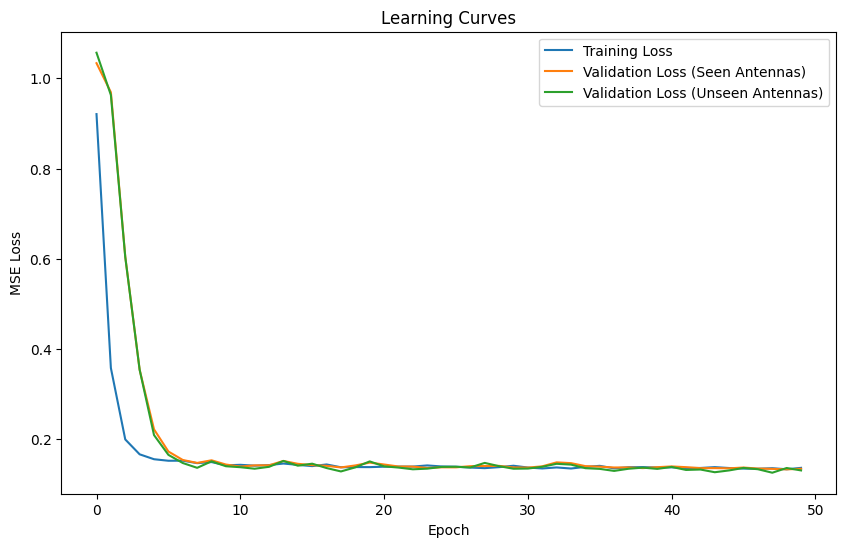

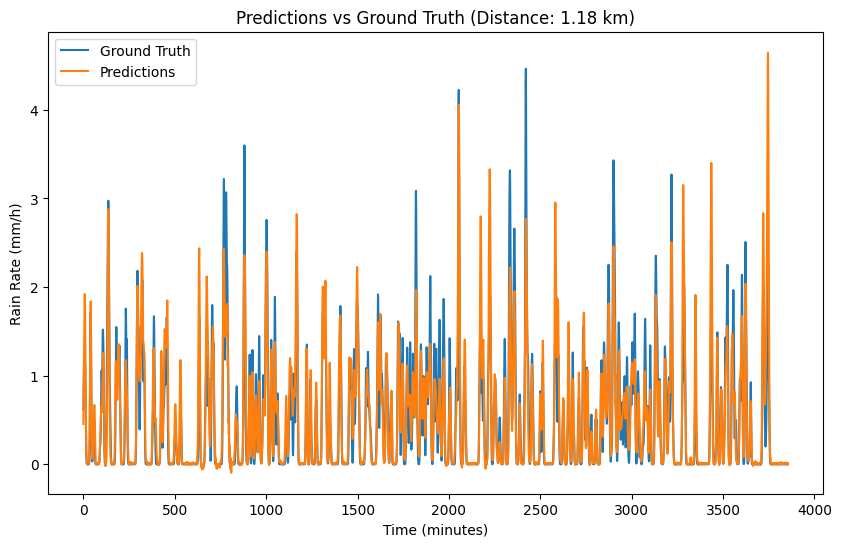

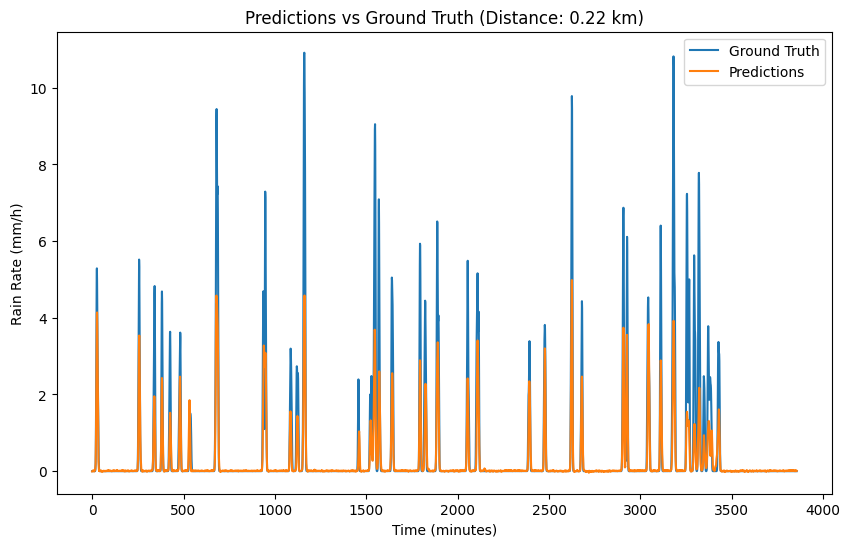

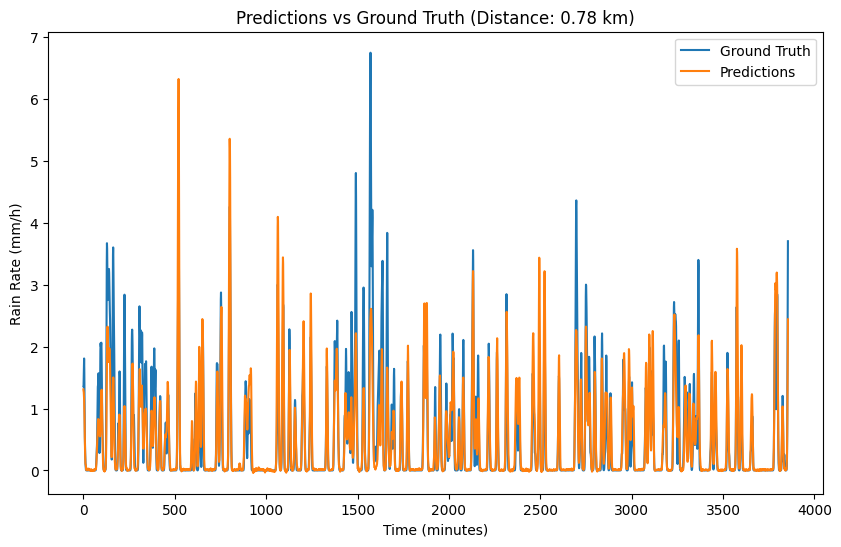

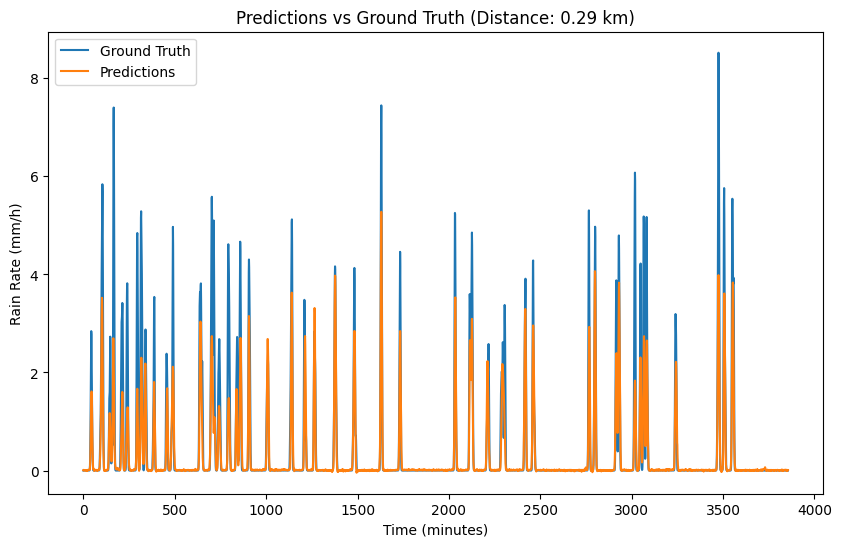

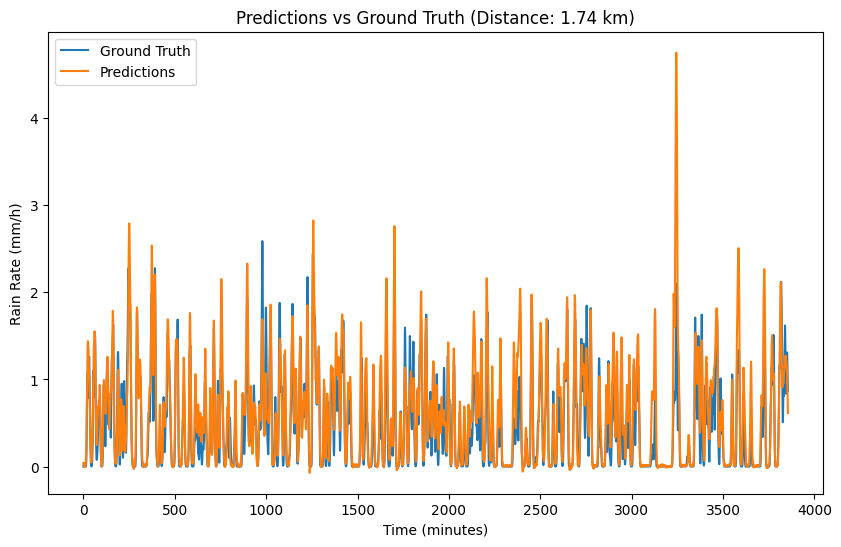

In [14]:
import torch
from torch import nn, optim
import matplotlib.pyplot as plt

# Model definition
n_channels = 1  # Single input channel for attenuations
n_classes = 1   # Single output channel for rain rates
model = UNet1D(n_channels, n_classes, size=32)

# Set device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Define DataLoaders
trainloader = create_dataloader(duration, idx2distance_train, batch_size)
valloader = create_dataloader(duration, idx2distance_val, batch_size, shuffle=False)

# Training and validation configurations
num_epochs = 50
train_losses, val_seen_losses, val_unseen_losses = [], [], []

# Training and validation loops
for epoch in range(num_epochs):
    # Training phase
    model.train()
    train_loss = 0
    for _, _, ground_truth, attenuations in trainloader:
        ground_truth, attenuations = ground_truth.to(device), attenuations.to(device)

        # Exclude 2-hour margins (120 minutes)
        ground_truth = ground_truth[:, 120:-120]
        if attenuations.ndim == 2:  # [batch_size, time_steps]
            attenuations = attenuations[:, 120:-120].unsqueeze(1)  # Add channel dimension
        elif attenuations.ndim == 3:  # [batch_size, time_steps, channels]
            attenuations = attenuations[:, :, 120:-120].permute(0, 2, 1)  # Rearrange to [batch_size, channels, time_steps]

        # Forward pass
        outputs = model(attenuations).squeeze(1)  # Remove channel dimension
        loss = criterion(outputs, ground_truth)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    train_losses.append(train_loss / len(trainloader))

    # Validation phase
    model.eval()
    val_seen_loss, val_unseen_loss = 0, 0
    with torch.no_grad():
        # Seen antenna pairs
        for _, _, ground_truth, attenuations in trainloader:
            ground_truth, attenuations = ground_truth.to(device), attenuations.to(device)
            ground_truth = ground_truth[:, 120:-120]
            if attenuations.ndim == 2:
                attenuations = attenuations[:, 120:-120].unsqueeze(1)
            elif attenuations.ndim == 3:
                attenuations = attenuations[:, :, 120:-120].permute(0, 2, 1)
            outputs = model(attenuations).squeeze(1)
            loss = criterion(outputs, ground_truth)
            val_seen_loss += loss.item()

        # Unseen antenna pairs
        for _, _, ground_truth, attenuations in valloader:
            ground_truth, attenuations = ground_truth.to(device), attenuations.to(device)
            ground_truth = ground_truth[:, 120:-120]
            if attenuations.ndim == 2:
                attenuations = attenuations[:, 120:-120].unsqueeze(1)
            elif attenuations.ndim == 3:
                attenuations = attenuations[:, :, 120:-120].permute(0, 2, 1)
            outputs = model(attenuations).squeeze(1)
            loss = criterion(outputs, ground_truth)
            val_unseen_loss += loss.item()

    val_seen_losses.append(val_seen_loss / len(trainloader))
    val_unseen_losses.append(val_unseen_loss / len(valloader))

    # Logging
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_losses[-1]:.4f}, "
          f"Val Seen Loss: {val_seen_losses[-1]:.4f}, Val Unseen Loss: {val_unseen_losses[-1]:.4f}")

# Plot learning curves
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label="Training Loss")
plt.plot(val_seen_losses, label="Validation Loss (Seen Antennas)")
plt.plot(val_unseen_losses, label="Validation Loss (Unseen Antennas)")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend()
plt.title("Learning Curves")
plt.show()

# Visualize predictions
model.eval()
example_batch = next(iter(valloader))
_, dists, ground_truth, attenuations = example_batch
ground_truth, attenuations = ground_truth.to(device), attenuations.to(device)

# Adjust dimensions for prediction
if attenuations.ndim == 2:
    attenuations = attenuations.unsqueeze(1)
elif attenuations.ndim == 3:
    attenuations = attenuations.permute(0, 2, 1)

with torch.no_grad():
    predictions = model(attenuations).squeeze(1)

# Plot predictions and ground truth for 5 examples
for i in range(5):
    plt.figure(figsize=(10, 6))
    plt.plot(ground_truth[i, 120:-120].cpu().numpy(), label="Ground Truth")
    plt.plot(predictions[i, 120:-120].cpu().numpy(), label="Predictions")
    plt.title(f"Predictions vs Ground Truth (Distance: {dists[i].item():.2f} km)")
    plt.xlabel("Time (minutes)")
    plt.ylabel("Rain Rate (mm/h)")
    plt.legend()
    plt.show()


## Partie II

Dans la première partie, le modèle était générique: la specificité de la paire d'antenne n'était pas prise en compte. On se propose de le faire en combinant un réseau générique à un perceptron spécifique, de sorte que la sortie $Z$ s'exprime sous la forme: \
$$Z = F(X, k) = f^{\tiny{Perceptron}}_{\alpha_k}(f^{\tiny{UNet}}_{\theta}(X))$$ \
 où $f^{\tiny{UNet}}_{\theta}(.)$ représente la fonction *forward* d'un UNet et $f^{\tiny{Perceptron}}_{\alpha_k}(.)$, la fonction forward du perceptron associé à la paire d'antennes d'identifiant $k$. \

Il s'agit donc en premier lieu d'adjoindre au UNet de la partie I autant de perceptrons que le jeu d'entraînement compte de paires d'antennes, ce qui se fait grâce aux lignes suivantes:

In [15]:
# Pour l'ajout de 1200 perceptrons à deux couches:
self.num_pairs = 1200
self.input_size_fc_layer = 5
self.hidden_size_fc_layer = 5
# Liste des premières couches
self.linears1 = nn.ModuleList([nn.Linear(self.input_size_fc_layer,
                                         self.hidden_size_fc_layer) for i in range(self.num_pairs)])
# Liste des secondes couches
self.linears2 = nn.ModuleList([nn.Linear(self.hidden_size_fc_layer,
                                         1) for i in range(self.num_pairs)])


NameError: name 'self' is not defined

**Consignes:** \
1) Définir une nouvelle classe de réseau en modifiant la classe UNet1D (dans utils_probleme1.py).
Ajouter ces perceptrons au réseau.

2) Fixer *self.n_classes* de façon à ce que la sortie du UNet soit compatible avec l'entrée du perceptron.

3) Modifications de la fonction forward:
- elle doit prendre comme arguments un batch d'entrées et un batch d'identifiants.

- après les étapes propres au UNet, elle doit appliquer le perceptron d'indice k à une série provenant de la paire n°k. La cellule de code suivante fournit un exemple dont on pourra directement s'inspirer.

4) Suivre les performances en généralisation sur les paires d'antennes du jeu d'entraînement et sur les deux cents paires de validation. Commenter.




In [ ]:
def apply_perceptron(self, UNet_output, ids):
    for i in range(ids.shape[0]):
        id = ids[i]
        # application de la première couche
        x = self.linears1[id](UNet_output[i].transpose(0,1).contiguous())
        x = self.relu(x)
        # application de la seconde couche
        x = self.linears2[id](x)
        # correction multiplicative de UNet_output
        UNet_output[i, 0] *= 1 + x.transpose(0,1).contiguous()
    return UNet_output[:,0]


In [ ]:
class CustomUNet1D(UNet1D):
    def __init__(self, n_channels, n_classes, num_pairs=1200, input_size_fc_layer=5, hidden_size_fc_layer=5, size=32):
        super(CustomUNet1D, self).__init__(n_channels, n_classes, size)

        # Additional attributes for perceptrons
        self.num_pairs = num_pairs
        self.input_size_fc_layer = input_size_fc_layer
        self.hidden_size_fc_layer = hidden_size_fc_layer

        # Define perceptrons
        self.linears1 = nn.ModuleList([
            nn.Linear(input_size_fc_layer, hidden_size_fc_layer) for _ in range(num_pairs)
        ])
        self.linears2 = nn.ModuleList([
            nn.Linear(hidden_size_fc_layer, 1) for _ in range(num_pairs)
        ])

        # Update n_classes to match perceptron input size
        self.n_classes = input_size_fc_layer

In [ ]:
def forward(self, X, ids):
    """
    Forward method with UNet processing and antenna-specific perceptrons.

    Args:
    - X: Input tensor of shape [batch_size, channels, time_steps].
    - ids: Antenna IDs corresponding to each input in the batch.

    Returns:
    - Z: Output tensor of shape [batch_size, time_steps].
    """
    # UNet forward pass
    X = super(CustomUNet1D, self).forward(X)  # UNet processing

    # Perceptron forward pass
    Z = []  # List to store outputs from perceptrons
    for i in range(len(ids)):
        k = ids[i].item()  # Extract antenna ID for sample `i`
        x_k = X[i]  # Extract corresponding UNet output for sample `i`

        # Apply perceptron for antenna `k`
        x_k = self.linears1[k](x_k)  # First layer of perceptron
        x_k = torch.relu(x_k)  # Activation function
        x_k = self.linears2[k](x_k)  # Second layer of perceptron

        Z.append(x_k)  # Append result for sample `i`

    # Combine outputs into a single tensor
    Z = torch.stack(Z, dim=0).squeeze(-1)  # Stack along batch dimension and remove extra dimension
    return Z


In [ ]:
# Instantiate the model
n_channels = 1
n_classes = 5  # Perceptron input size
model = CustomUNet1D(n_channels, n_classes, num_pairs=1200, input_size_fc_layer=5, hidden_size_fc_layer=5, size=32)
model = model.to(device)

# Loss and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for ids, _, ground_truth, attenuations in trainloader:
        ground_truth, attenuations, ids = ground_truth.to(device), attenuations.to(device), ids.to(device)

        # Exclude 2-hour margins
        ground_truth = ground_truth[:, 120:-120]
        attenuations = attenuations[:, :, 120:-120].permute(0, 2, 1)

        # Forward pass
        outputs = model(attenuations, ids)
        loss = criterion(outputs, ground_truth)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
    print(f"Epoch {epoch+1}, Loss: {train_loss / len(trainloader):.4f}")


In [ ]:
# Validation
model.eval()
val_loss = 0
with torch.no_grad():
    for ids, _, ground_truth, attenuations in valloader:
        ground_truth, attenuations, ids = ground_truth.to(device), attenuations.to(device), ids.to(device)

        ground_truth = ground_truth[:, 120:-120]
        attenuations = attenuations[:, :, 120:-120].permute(0, 2, 1)

        outputs = model(attenuations, ids)
        loss = criterion(outputs, ground_truth)
        val_loss += loss.item()

print(f"Validation Loss: {val_loss / len(valloader):.4f}")


## Partie III

La solution proposée dans la partie II a un défaut: les performances chutent sur les paires d'antennes qui n'ont pas été rencontrées pendant l'entraînement. Pour le corriger, on se propose de suivre la méthode suivante:
- ajouter un perceptron "générique" de même architecture que les perceptrons spécifiques.
- entraîner le réseau de la partie II en remplaçant une fois sur quatre l'identifiant de la paire d'antennes par l'indice du perceptron générique.
- après cinquante époques, geler les poids de la partie générique et prolonger l'apprentissage des perceptrons spécifiques sur une vingtaine d'époque.

**Consignes:** \

1) Mettre en oeuvre cette méthode

2) Conclure sur son efficacité